<a href="https://colab.research.google.com/github/abeersethia/CCM_EEG/blob/main/UNetDemo1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

torch.manual_seed(42)
np.random.seed(42)

In [1]:
def generate_lorenz(sigma=10.0, beta=8/3, rho=28.0, dt=0.01, T=50.0, init=(1.0, 1.0, 1.0)):
    def lorenz(t, state):
        x, y, z = state
        dx = sigma * (y - x)
        dy = x * (rho - z) - y
        dz = x * y - beta * z
        return [dx, dy, dz]

    t_eval = np.arange(0, T, dt)
    sol = solve_ivp(lorenz, (0, T), init, t_eval=t_eval, rtol=1e-9, atol=1e-9)
    traj = sol.y.T  # shape (N, 3)
    return traj[:, 0], t_eval  # return only x-dimension

In [3]:
def build_hankel_rows(signal, window_len, stride=512):
    T = len(signal)
    starts = list(range(0, T - window_len + 1, stride))
    rows = np.stack([signal[s:s+window_len] for s in starts], axis=0)
    return rows, starts


class HankelWindowDataset(Dataset):
    def __init__(self, signal, window_len=1024, stride=512, normalize=True):
        self.signal = signal.astype(np.float32)
        self.window_len = window_len
        self.stride = stride
        self.rows, self.starts = build_hankel_rows(self.signal, window_len, stride)
        self.inputs = self.rows[:, None, :]  # (N, 1, L)
        self.targets = self.rows[:, None, :] # same as inputs (autoencoder)
        if normalize:
            self.mean = self.inputs.mean()
            self.std = self.inputs.std() + 1e-8
            self.inputs = (self.inputs - self.mean) / self.std
            self.targets = (self.targets - self.mean) / self.std
        else:
            self.mean = 0.0
            self.std = 1.0

    def __len__(self):
        return self.inputs.shape[0]

    def __getitem__(self, idx):
        return torch.from_numpy(self.inputs[idx]).float(), torch.from_numpy(self.targets[idx]).float()


In [4]:
class ConvBlock1D(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, padding=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, kernel_size, padding=padding),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_ch, out_ch, kernel_size, padding=padding),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.net(x)


class CompressedAutoencoder1D(nn.Module):
    def __init__(self, input_channels=1, base_channels=16, depth=3,
                 latent_dim=32, input_length=1024):
        super().__init__()
        self.input_length = input_length

        # Encoder
        enc_layers = []
        in_ch = input_channels
        for i in range(depth):
            out_ch = base_channels * (2 ** i)
            enc_layers.append(ConvBlock1D(in_ch, out_ch))
            enc_layers.append(nn.Conv1d(out_ch, out_ch, kernel_size=4, stride=2, padding=1))
            in_ch = out_ch
        self.encoder = nn.Sequential(*enc_layers)
        self.enc_out_ch = in_ch

        # Global pooling + latent
        self.to_latent = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(self.enc_out_ch, latent_dim)
        )

        # Latent → feature map
        self.from_latent = nn.Sequential(
            nn.Linear(latent_dim, self.enc_out_ch),
            nn.Unflatten(1, (self.enc_out_ch, 1))
        )

        # Decoder
        dec_layers = []
        for i in reversed(range(depth)):
            out_ch = base_channels * (2 ** i)
            dec_layers.append(nn.ConvTranspose1d(in_ch, out_ch, kernel_size=4, stride=2, padding=1))
            dec_layers.append(ConvBlock1D(out_ch, out_ch))
            in_ch = out_ch
        self.decoder = nn.Sequential(*dec_layers)
        self.final_conv = nn.Conv1d(in_ch, 1, kernel_size=1)

    def encode(self, x):
        h = self.encoder(x)
        z = self.to_latent(h)
        return z

    def decode(self, z, target_length=None):
        h = self.from_latent(z)
        out = self.decoder(h)
        out = self.final_conv(out)
        if target_length is not None and out.shape[-1] != target_length:
            out = nn.functional.interpolate(out, size=target_length, mode='linear', align_corners=False)
        return out

    def forward(self, x):
        z = self.encode(x)
        out = self.decode(z, target_length=x.shape[-1])
        return out, z

In [5]:
def train_model(model, dataloader, n_epochs=30, lr=1e-3, device='cpu'):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in range(1, n_epochs + 1):
        model.train()
        total_loss = 0.0
        for xb, yb in dataloader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            pred, _ = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            opt.step()
            total_loss += loss.item() * xb.size(0)

        avg_loss = total_loss / len(dataloader.dataset)
        print(f"Epoch {epoch:02d}/{n_epochs} - MSE: {avg_loss:.6e}")
    return model

In [6]:
def overlap_add_reconstruct(pred_windows, starts, T, window_fn=None):
    recon_agg = np.zeros(T, dtype=np.float32)
    counts = np.zeros(T, dtype=np.float32)
    N, _, L = pred_windows.shape

    if window_fn is None:
        window = np.ones(L, dtype=np.float32)
    else:
        window = window_fn(L).astype(np.float32)

    for i in range(N):
        s = starts[i]
        win = pred_windows[i, 0] * window
        recon_agg[s:s+L] += win
        counts[s:s+L] += window

    mask = counts > 0
    recon = np.zeros_like(recon_agg)
    recon[mask] = recon_agg[mask] / counts[mask]
    return recon


Generated signal length: 2000
Epoch 01/500 - MSE: 1.006694e+00
Epoch 02/500 - MSE: 1.043970e+00
Epoch 03/500 - MSE: 9.430886e-01
Epoch 04/500 - MSE: 8.076243e-01
Epoch 05/500 - MSE: 7.813735e-01
Epoch 06/500 - MSE: 7.548314e-01
Epoch 07/500 - MSE: 7.513220e-01
Epoch 08/500 - MSE: 7.382612e-01
Epoch 09/500 - MSE: 7.299362e-01
Epoch 10/500 - MSE: 7.232319e-01
Epoch 11/500 - MSE: 7.120200e-01
Epoch 12/500 - MSE: 7.103565e-01
Epoch 13/500 - MSE: 7.045921e-01
Epoch 14/500 - MSE: 6.939128e-01
Epoch 15/500 - MSE: 6.915087e-01
Epoch 16/500 - MSE: 6.869217e-01
Epoch 17/500 - MSE: 6.824655e-01
Epoch 18/500 - MSE: 6.785433e-01
Epoch 19/500 - MSE: 6.749935e-01
Epoch 20/500 - MSE: 6.725994e-01
Epoch 21/500 - MSE: 6.712230e-01
Epoch 22/500 - MSE: 6.701563e-01
Epoch 23/500 - MSE: 6.692191e-01
Epoch 24/500 - MSE: 6.687310e-01
Epoch 25/500 - MSE: 6.685410e-01
Epoch 26/500 - MSE: 6.680459e-01
Epoch 27/500 - MSE: 6.674255e-01
Epoch 28/500 - MSE: 6.669999e-01
Epoch 29/500 - MSE: 6.669509e-01
Epoch 30/500 

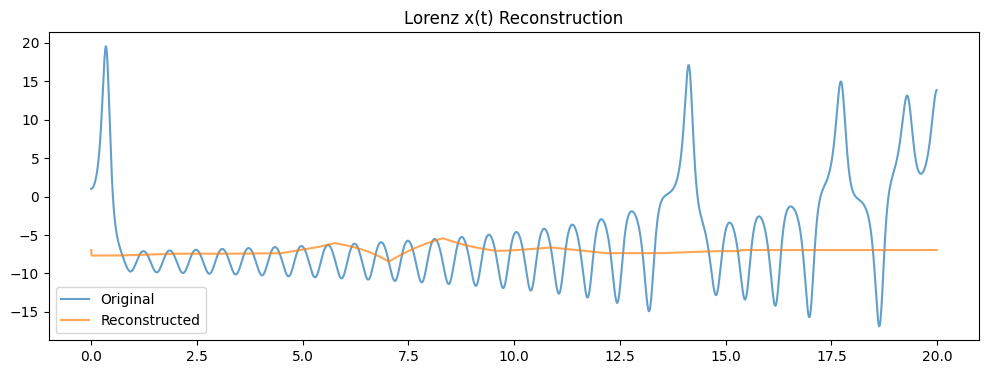

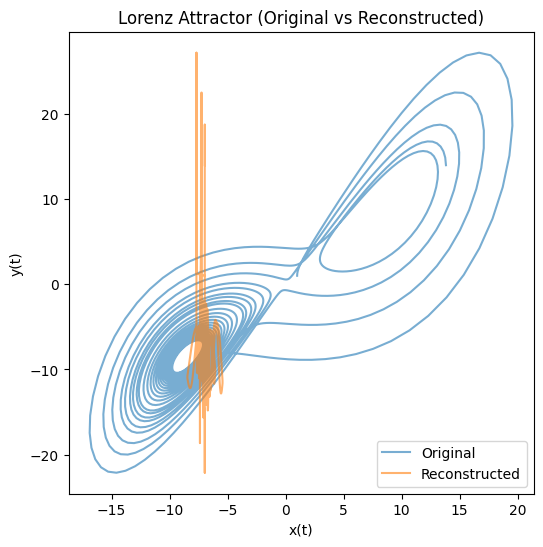

In [13]:
if __name__ == "__main__":
    # Generate Lorenz x(t), y(t), z(t)
    def generate_lorenz_full(sigma=10.0, beta=8/3, rho=28.0, dt=0.01, T=20.0, init=(1.0, 1.0, 1.0)):
        def lorenz(t, state):
            x, y, z = state
            dx = sigma * (y - x)
            dy = x * (rho - z) - y
            dz = x * y - beta * z
            return [dx, dy, dz]

        t_eval = np.arange(0, T, dt)
        sol = solve_ivp(lorenz, (0, T), init, t_eval=t_eval, rtol=1e-9, atol=1e-9)
        return sol.y.T, t_eval  # shape (N, 3), t_eval

    traj, t = generate_lorenz_full(T=20.0, dt=0.01)
    x = traj[:, 0]
    y = traj[:, 1]
    z = traj[:, 2]

    print(f"Generated signal length: {len(x)}")

    # Dataset uses only x(t)
    window_len = 1024
    stride = 512
    dataset = HankelWindowDataset(x, window_len=window_len, stride=stride, normalize=True)
    loader = DataLoader(dataset, batch_size=32, shuffle=True)

    # Model
    model = CompressedAutoencoder1D(input_channels=1, base_channels=16,
                                    depth=3, latent_dim=32, input_length=window_len)

    # Train
    model = train_model(model, loader, n_epochs=500, lr=1e-3,
                        device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

    # Reconstruct signal
    model.eval()
    preds = []
    with torch.no_grad():
        for xb, _ in loader:
            xb = xb.to(next(model.parameters()).device)
            out, _ = model(xb)
            preds.append(out.cpu().numpy())
    preds = np.concatenate(preds, axis=0)

    recon = overlap_add_reconstruct(preds, dataset.starts, len(x),
                                    window_fn=np.hanning)

    # Denormalize
    recon = recon * dataset.std + dataset.mean

    # Plot time-series reconstruction
    plt.figure(figsize=(12, 4))
    plt.plot(t, x, label="Original", alpha=0.7)
    plt.plot(t[:len(recon)], recon, label="Reconstructed", alpha=0.7)
    plt.legend()
    plt.title("Lorenz x(t) Reconstruction")
    plt.show()

    # Plot original vs reconstructed attractor
    plt.figure(figsize=(6, 6))
    plt.plot(x, y, label="Original", alpha=0.6)
    plt.plot(recon[:len(y)], y[:len(recon)], label="Reconstructed", alpha=0.6)
    plt.xlabel("x(t)")
    plt.ylabel("y(t)")
    plt.title("Lorenz Attractor (Original vs Reconstructed)")
    plt.legend()
    plt.show()